<a href="https://colab.research.google.com/github/tomholmes96/ca-portfolio-opti/blob/main/Portfolio_Optimisation_CA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.optimize as sco

# Pulling the Stock Data

In [ ]:
tech_symbols = ['MSFT', 'AMZN', 'AAPL', 'GOOGL', 'FB', 'NVDA', 'NFLX', 'PYPL', 'SQ', 'TSLA']
gold_symbols = ['AU', 'GOLD', 'CEY.L', 'SGLN.L', 'PAAS', 'POLY.L', 'PHSP.L', 'AUY', 'BTG', 'KGC']
index_symbols = ['VWRL.L', 'VFEM.L', 'VUSA.L', 'VMIG.L']
all_symbols = tech_symbols + gold_symbols + index_symbols
start_date = datetime(2019, 12, 8)
end_date = datetime(2020, 12, 7)
my_stocks = web.get_data_yahoo(tech_symbols, start_date, end_date)
my_stocks

Attributes   Adj Close               ...      Volume            
Symbols           MSFT         AMZN  ...          SQ        TSLA
Date                                 ...                        
2019-12-09  149.773361  1749.510010  ...   4335100.0  45115500.0
2019-12-10  149.545792  1739.209961  ...   6047200.0  44141500.0
2019-12-11  150.109772  1748.719971  ...   6518000.0  34489000.0
2019-12-12  151.633667  1760.329956  ...   4827300.0  38819500.0
2019-12-13  152.910126  1760.939941  ...   7047500.0  32854500.0
...                ...          ...  ...         ...         ...
2020-11-30  214.070007  3168.040039  ...  14091100.0  63003100.0
2020-12-01  216.210007  3220.080078  ...  10814400.0  40382800.0
2020-12-02  215.369995  3203.530029  ...  10483700.0  47775700.0
2020-12-03  214.240005  3186.729980  ...   6918200.0  42552000.0
2020-12-04  214.360001  3162.580078  ...   6557100.0  29059200.0

[251 rows x 60 columns]

In [ ]:
adj_price_of_portfolio = my_stocks['Adj Close']
adj_price_of_portfolio.head()

Symbols,MSFT,AMZN,AAPL,GOOGL,FB,NVDA,NFLX,PYPL,SQ,TSLA
Date,,,,,,,,,,
2019-12-09,149.773361,1749.510010,65.621384,1342.989990,201.339996,211.820480,302.500000,103.779999,67.059998,67.905998
2019-12-10,149.545792,1739.209961,66.004898,1342.890015,200.869995,213.627502,293.119995,103.620003,65.839996,69.767998
2019-12-11,150.109772,1748.719971,66.567886,1344.250000,202.259995,216.981964,298.929993,105.510002,65.750000,70.540001
2019-12-12,151.633667,1760.329956,66.737518,1348.489990,196.750000,223.700897,298.440002,105.669998,65.860001,71.935997
2019-12-13,152.910126,1760.939941,67.644707,1346.869995,194.110001,223.621002,298.500000,107.650002,64.800003,71.678001


# Mean and Variance Graphs

I work in dark mode, so I set the text to white:

In [ ]:
COLOR = 'white'
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

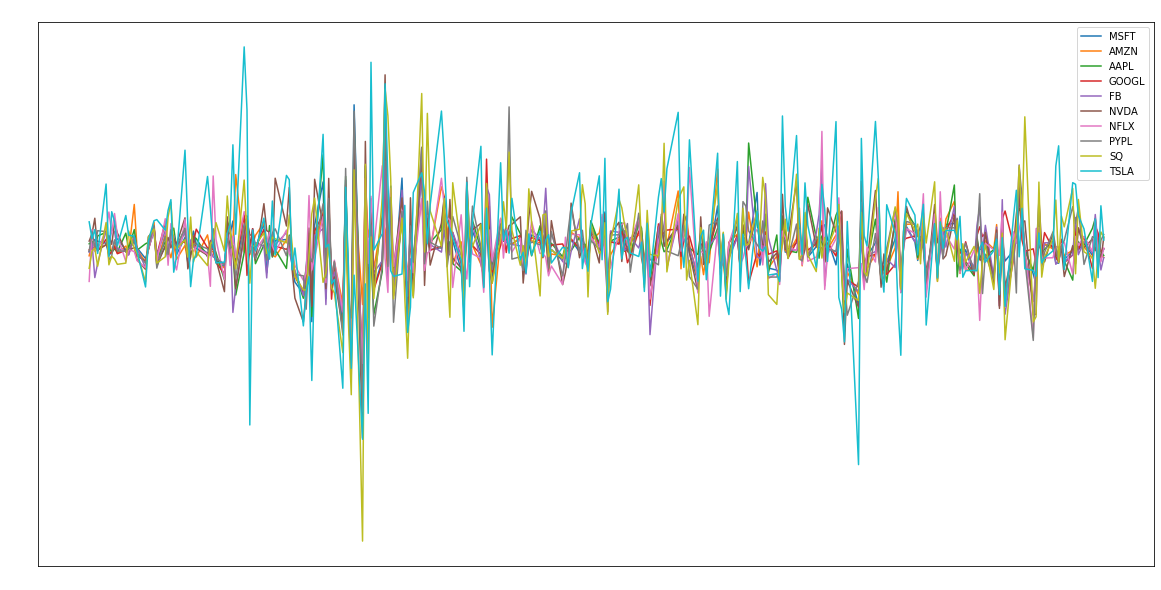

In [ ]:
daily_returns = adj_price_of_portfolio.pct_change()
plt.figure(figsize=(20,10))
plt.title('Return over time', fontdict={'color':'white'})
plt.plot(daily_returns)
plt.legend(daily_returns.columns);

**Reward**

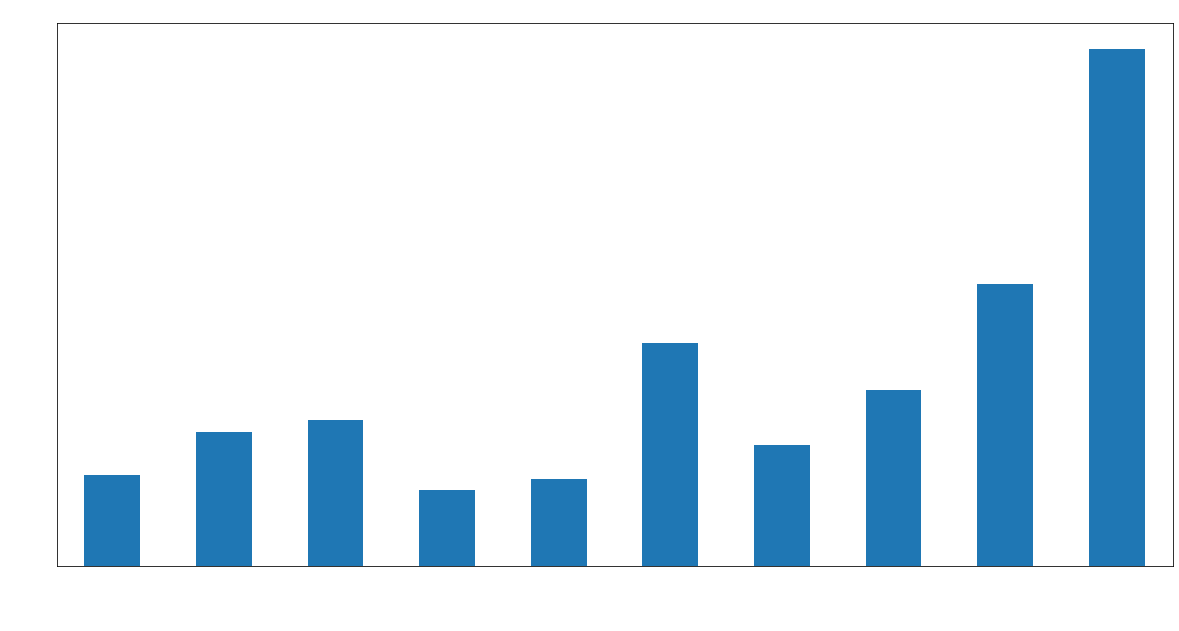

In [ ]:
mean_daily_returns = daily_returns.mean()
plt.title('Mean Daily RoR for Stocks - July 2017 to October 2020', fontdict={'color':'white'})
mean_daily_returns.plot(figsize=(20,10), kind='bar', ylabel='Mean Daily RoR');

Symbols
MSFT      43.122915
AMZN      80.769476
AAPL      86.295980
GOOGL     35.798481
FB        38.919250
NVDA     156.032852
NFLX      64.730578
PYPL     109.838126
SQ       210.393680
TSLA     782.160624
dtype: float64

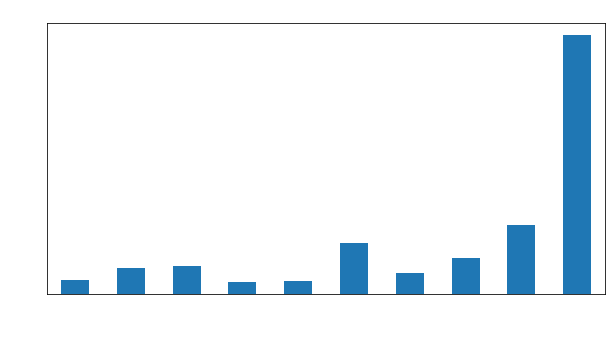

In [ ]:
total_return_over_year = ((adj_price_of_portfolio.iloc[-1] - adj_price_of_portfolio.iloc[0]) / adj_price_of_portfolio.iloc[0]) * 100

plt.title('%age Total Return for Stocks - December 2019 to November 2020', fontdict={'color':'white'})
total_return_over_year.plot(kind='bar', figsize=(10,5), ylabel='%age Return');

total_return_over_year

**Risk**

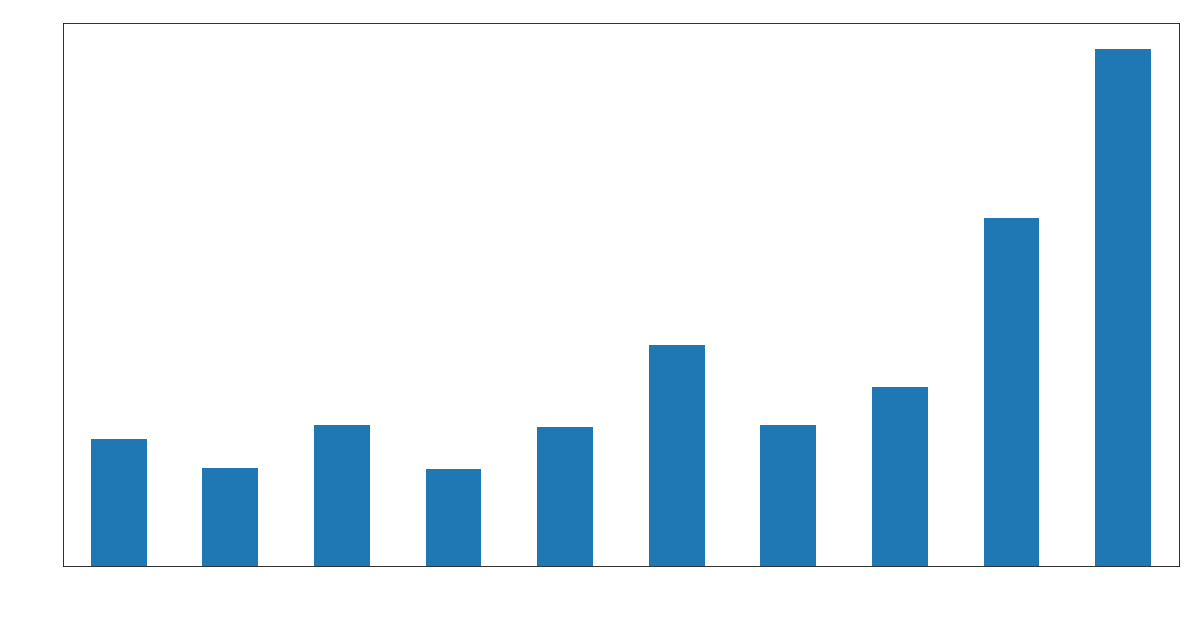

In [ ]:
daily_variance_of_stocks = daily_returns.var()
plt.title('Mean Daily Variance for Stocks - July 2017 to October 2020', fontdict={'color':'white'})
daily_variance_of_stocks.plot(kind='bar', figsize=(20,10), ylabel='Daily Variance');

# Efficient Frontier Calculation

Normalised returns:

In [ ]:
log_ret = np.log(adj_price_of_portfolio / adj_price_of_portfolio.shift(1))
log_ret.head()

Symbols,MSFT,AMZN,AAPL,GOOGL,FB,NVDA,NFLX,PYPL,SQ,TSLA
Date,,,,,,,,,,
2019-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-10,-0.001521,-0.005905,0.005827,-0.000074,-0.002337,0.008495,-0.031499,-0.001543,-0.018360,0.027051
2019-12-11,0.003764,0.005453,0.008493,0.001012,0.006896,0.015580,0.019627,0.018075,-0.001368,0.011005
2019-12-12,0.010101,0.006617,0.002545,0.003149,-0.027620,0.030496,-0.001640,0.001515,0.001672,0.019597
2019-12-13,0.008383,0.000346,0.013502,-0.001202,-0.013509,-0.000357,0.000201,0.018564,-0.016226,-0.003593


In [ ]:
np.random.seed(42)
num_portfolios = 25000
all_weights = np.zeros((num_portfolios, len(adj_price_of_portfolio.columns)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for x in range(num_portfolios):
    # Weights
    weights = np.array(np.random.random(len(adj_price_of_portfolio.columns))) # Number of stocks
    weights = weights / np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected return
    ret_arr[x] = np.sum((log_ret.mean() * weights * 252))

    # Expected volitility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe ratio
    sharpe_arr[x] = ret_arr[x] / vol_arr[x]


In [ ]:
print("The max Sharpe ratio is:", sharpe_arr.max())
print("Its location in the array:", sharpe_arr.argmax())

The max Sharpe ratio is: 2.2828979798641953
Its location in the array: 5079


Get all the allocations for this max:

In [ ]:
max_sr_rates = all_weights[sharpe_arr.argmax(),:]
print(max_sr_rates)

max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

[4.59978330e-02 1.16726282e-01 1.76308039e-01 2.50395706e-04
 6.38953162e-02 5.90905965e-02 8.52286632e-02 5.58714481e-02
 6.56432638e-02 3.30988162e-01]


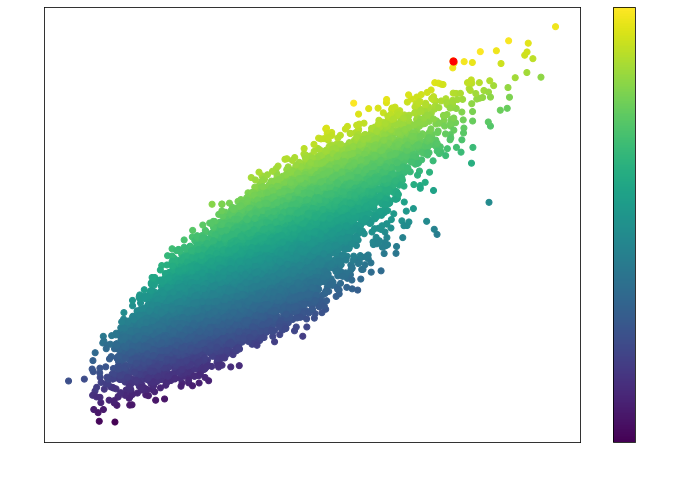

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volitility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50); # Red dot

Allocation to my tech investment pie adjusted to exclude my allocation towards the Vanguard ETFs:

In [ ]:
formatted_allocs = [ '%.2f' % (elem * 43) for elem in max_sr_rates ]
max_allocation = pd.DataFrame(formatted_allocs, adj_price_of_portfolio.columns, columns=["%age Allocation"])
max_allocation

,%age Allocation
Symbols,
MSFT,1.98
AMZN,5.02
AAPL,7.58
GOOGL,0.01
FB,2.75
NVDA,2.54
NFLX,3.66
PYPL,2.40
SQ,2.82


In [ ]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

Moving on, we will need to create a variable to include our constraints like the check_sum. We’ll also define an initial guess and specific bounds, to help the minimization be faster and more efficient. Our initial guess will be equal for each stock (or 1/24), and the bounds will be a tuple (0,1) for each stock, since the weight can range from 0 to 1.

In [ ]:
cons = ({'type': 'eq', 'fun': check_sum})
bounds = [(0,1) for x in range(len(adj_price_of_portfolio.columns))]
bounds = tuple(bounds)
equal_weight = 1 / len(adj_price_of_portfolio)
init_guess = [equal_weight for x in range(len(adj_price_of_portfolio.columns))]

Enter the minimize function. I chose the method ‘SLSQP’ because it’s the method used for most of the generic minimization problems. In case you are wondering, it stands for Sequential Least Squares Programming. Make sure to pass the initial method, the bounds and the constraints with the variables defined above. If we print the variable it will look like this:

In [ ]:
opt_results = sco.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_results)

     fun: -2.5119683302192573
     jac: array([ 5.55795342e-01,  1.54644251e-04,  1.41396821e-01,  4.00122404e-01,
        4.48392868e-01, -5.58584929e-04,  1.47677630e-01, -1.83194876e-04,
        7.25060701e-04, -7.27176666e-05])
 message: 'Optimization terminated successfully.'
    nfev: 184
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([5.88338890e-17, 2.19997413e-01, 0.00000000e+00, 5.13269042e-17,
       0.00000000e+00, 2.08118198e-02, 2.43561240e-17, 7.48062412e-02,
       4.97019447e-02, 6.34682582e-01])


We want the key x from the dictionary, which is an array with the weights of the portfolio that has the maximum Sharpe ratio. If we use our function get_ret_vol_sr we get the return, volatility, and sharpe ratio:

In [ ]:
get_ret_vol_sr(opt_results.x)

array([1.6565363 , 0.65945748, 2.51196833])

So we got a better Sharpe ratio than we got with the simulation we did before.

In [ ]:
formatted_allocs = [ '%.2f' % (elem * 43) for elem in opt_results.x ]
max_allocation = pd.DataFrame(formatted_allocs, adj_price_of_portfolio.columns, columns=["%age Allocation"])
max_allocation

,%age Allocation
Symbols,
MSFT,0.00
AMZN,9.46
AAPL,0.00
GOOGL,0.00
FB,0.00
NVDA,0.89
NFLX,0.00
PYPL,3.22
SQ,2.14


We’re now ready to check all optimal portfolios, which is basically our efficient frontier. The efficient frontier is the set of portfolios that gets us the highest expected return for any given risk level. Or from another perspective, the minimum amount of risk for an expected return. To trace this line, we can define a variable frontier_y. Going back to the chart above, we can see the maximum return doesn’t go much higher than 0.3, so frontier_y will be defined from 0 to 0.3.

In [ ]:
frontier_y = np.linspace(0.3,1.0,200)

To finish the plotting of the frontier, we have define one last function that will help us minimize the volatility. It will return the volatility (index 1) of the given weights.

In [ ]:
def minimise_volitility(weights):
    return get_ret_vol_sr(weights)[1]

And now the last bit of code to help us get get our x values for the efficient frontier. We use the same code as above with a few changes to the constraints. The for loop is basically going through every possible value in our previously defined frontier_y and obtaining the minimum result (which is the key ‘fun’) of volatility (our x axis in the chart).

In [ ]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = sco.minimize(minimise_volitility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

Finally we can plot the actual efficient frontier by passing the variables frontier_x and frontier_y.

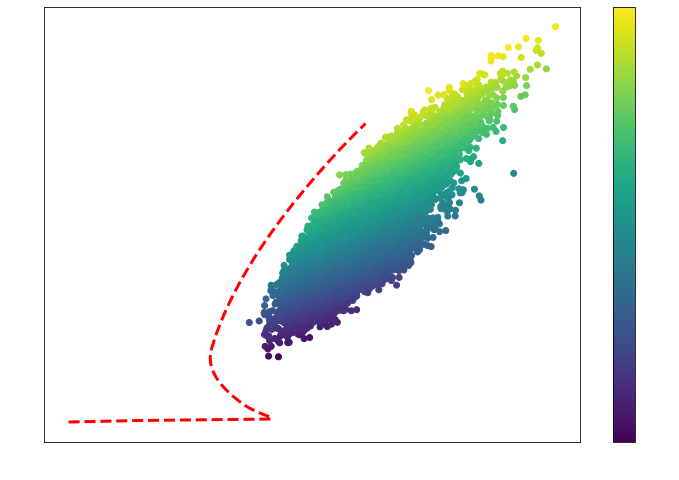

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3);

# New section

In [ ]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    no_of_stocks = len(adj_price_of_portfolio.columns)
    for i in range(num_portfolios):
        weights = np.random.random(no_of_stocks) #Needs to equal the number of stocks
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [ ]:
risk_free_rate = .13 / 100
num_portfolios = 25000
cov_matrix = daily_returns.cov()

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=adj_price_of_portfolio.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=adj_price_of_portfolio.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier', fontdict={'color':'white'})
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    return max_sharpe_allocation, min_vol_allocation

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.66
Annualised Volatility: 0.6


Symbols     MSFT  AMZN  AAPL  GOOGL   FB   NVDA  NFLX  PYPL     SQ   TSLA
allocation  4.37  0.52  1.24   3.22  1.9  21.98  0.47   1.6  28.33  36.38
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.65
Annualised Volatility: 0.38


Symbols     MSFT   AMZN  AAPL  GOOGL     FB  NVDA  NFLX  PYPL    SQ  TSLA
allocation  3.64  18.89  4.21  25.41  10.19  5.15  19.4  9.89  0.87  2.35


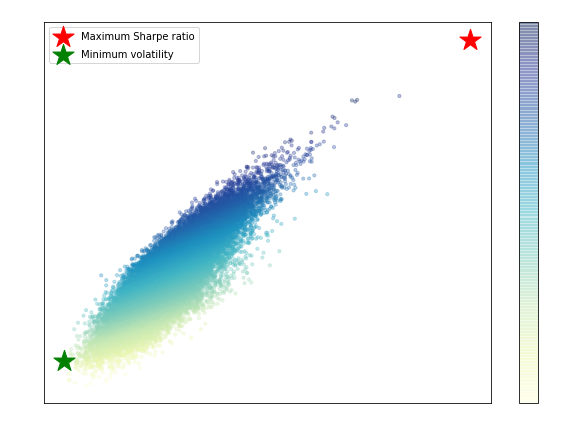

In [ ]:
max_sharpe_alloc, min_vol_alloc = display_simulated_ef_with_random(mean_daily_returns, cov_matrix, num_portfolios, risk_free_rate)

Calculation for how much I would invest in each assest for a certain amount of cash:

**High Reward, High Risk:**

In [ ]:
total_cash_invested = 1168.78

trans_max_sharpe = max_sharpe_alloc.T
trans_max_sharpe['Invest'] = trans_max_sharpe['allocation'] / 100 * total_cash_invested
trans_max_sharpe['Invest'] = trans_max_sharpe['Invest'].round(2)
trans_max_sharpe

,allocation,Invest
Symbols,,
MSFT,4.37,51.08
AMZN,0.52,6.08
AAPL,1.24,14.49
GOOGL,3.22,37.63
FB,1.90,22.21
NVDA,21.98,256.90
NFLX,0.47,5.49
PYPL,1.60,18.70
SQ,28.33,331.12


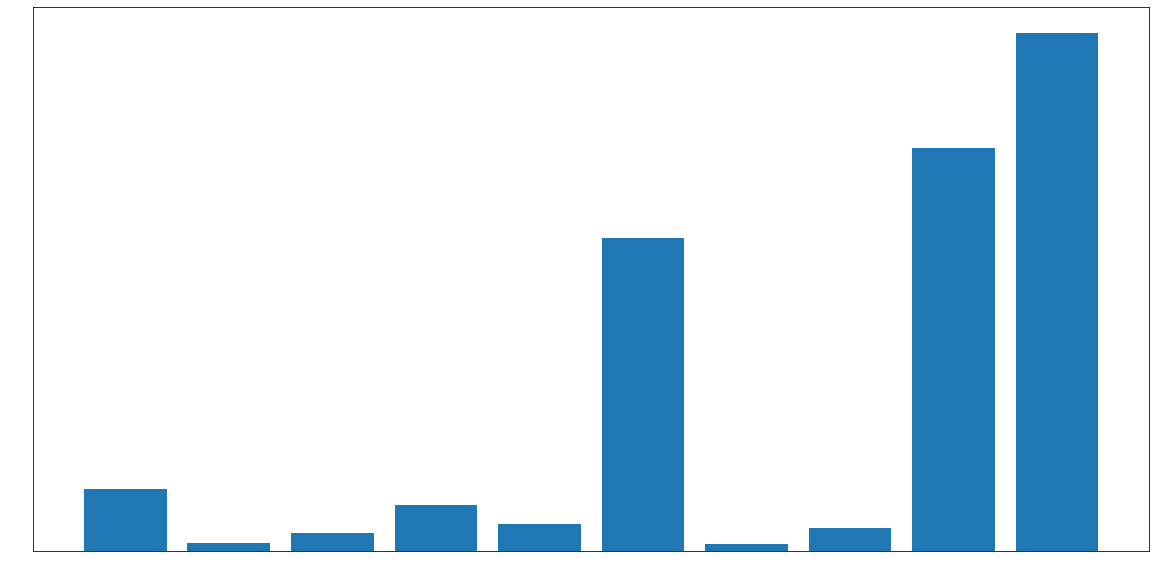

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(trans_max_sharpe.index, trans_max_sharpe['Invest']);

**Low Reward, Low Risk:**

In [ ]:
trans_vol_alloc = min_vol_alloc.T
trans_vol_alloc['Invest'] = trans_vol_alloc['allocation'] / 100 * total_cash_invested
trans_vol_alloc['Invest'] = trans_vol_alloc['Invest'].round(2)
trans_vol_alloc

,allocation,Invest
Symbols,,
MSFT,3.64,42.54
AMZN,18.89,220.78
AAPL,4.21,49.21
GOOGL,25.41,296.99
FB,10.19,119.10
NVDA,5.15,60.19
NFLX,19.40,226.74
PYPL,9.89,115.59
SQ,0.87,10.17


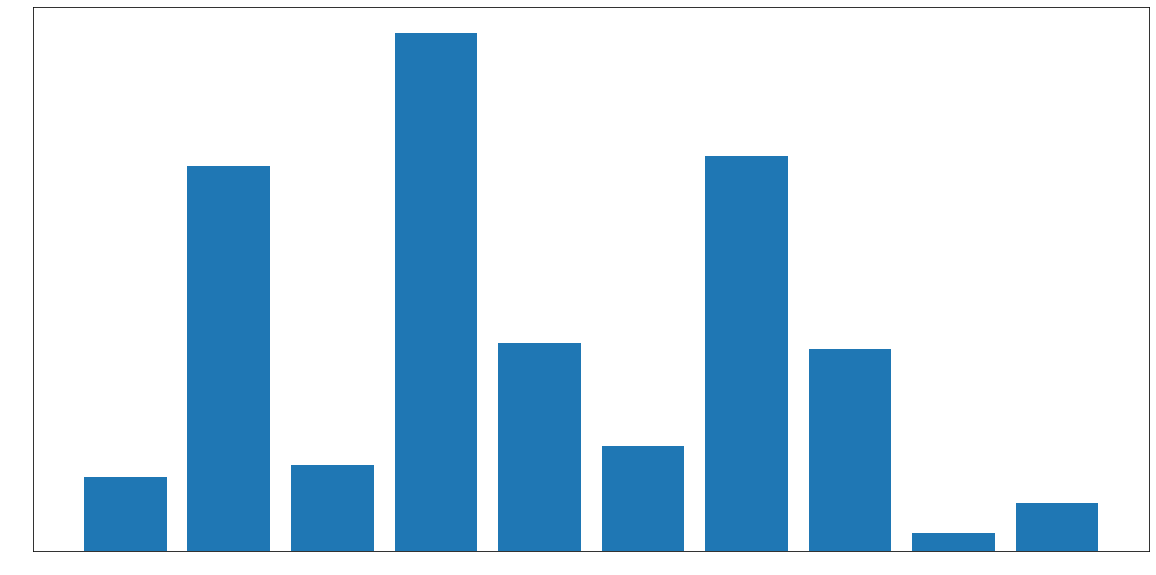

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(trans_vol_alloc.index, trans_vol_alloc['Invest']);